In [5]:
import csv
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
Y_samples = []
dY_samples = []

system = 'Lorenz63'
filter_methods = ['ssplines','tikhonov_hp','trendfilter']
n_filters = len(filter_methods)

#Load true dynamical system data
filepath_xt = 'data_files/' + system + '_dynamics.csv'
dynamics = np.genfromtxt(filepath_xt, delimiter=',')

t = dynamics[0]
data = dynamics[1:]
t_samples = len(t)
trim = int(np.floor(5 / 100 * t_samples))

n_states = int(data.shape[0] / 2)
X = data[0:n_states,trim:-trim]
DX = data[n_states:,trim:-trim]
tt = t[trim:-trim]
n_samples = 100

noise_lvls = [0.001, 0.01, 0.1, 1]
n_noise_lvls = len(noise_lvls)

mean_X_error = np.zeros((n_states, n_noise_lvls, n_filters))
mean_dX_error = np.zeros((n_states, n_noise_lvls, n_filters))

var_X_error = np.zeros((n_states, n_noise_lvls, n_filters))
var_dX_error = np.zeros((n_states, n_noise_lvls, n_filters))

error_X = np.zeros((n_samples,n_states))
error_dX = np.zeros((n_samples,n_states))

for filter_idx, filter_method in enumerate(filter_methods):
    
    for noise_lvl, sigma in enumerate(noise_lvls):

        #Load sample observations
        for state in range(n_states):

            filepath_y = 'data_files/' + filter_method + '/' + system + '_' + filter_method + '_' + str(sigma) + '_Y' + str(state+1) + '.csv'
            y = np.genfromtxt(filepath_y, delimiter=',')
            Y_samples.append(y)

            filepath_dy = 'data_files/' + filter_method+ '/' + system + '_' + filter_method + '_' + str(sigma) + '_dY' + str(state+1) + '.csv'
            dy = np.genfromtxt(filepath_dy, delimiter=',')
            dY_samples.append(dy)

            n_samples = y.shape[0]
            for sample in range(n_samples):

                error_X[sample,state] = norm(y[sample,:] - X[state,:]) / norm(X[state,:])
                error_dX[sample,state] = norm(dy[sample,:] - DX[state,:]) / norm(DX[state,:])

            mean_X_error[state, noise_lvl, filter_idx] = error_X[:,state].mean()
            mean_dX_error[state, noise_lvl, filter_idx] = error_dX[:,state].mean()
            var_X_error[state, noise_lvl, filter_idx] = error_X[:,state].var()
            var_dX_error[state, noise_lvl, filter_idx] = error_dX[:,state].var()

    

ssplines            tikhonov_hp            trendfilter  \
                    mean error var. error  mean error var. error  mean error   
$\sigma$ = 0.001 x1 8.9470E-05 3.6095E-11  1.2613E-04 3.6607E-11  9.8769E-05   
                 x2 1.0980E-04 3.7841E-11  1.0269E-04 2.8912E-11  8.5196E-05   
                 x3 4.7870E-05 5.7400E-12  4.1997E-05 3.8184E-12  3.4347E-05   
$\sigma$ = 0.01  x1 7.1676E-04 2.7043E-09  7.5400E-04 2.4860E-09  7.8565E-04   
                 x2 6.2395E-04 2.5835E-09  9.4143E-04 1.1110E-08  8.7015E-04   
                 x3 2.5228E-04 3.1357E-10  2.7916E-04 8.0725E-10  2.9316E-04   
$\sigma$ = 0.1   x1 6.3157E-03 4.0997E-07  5.4956E-03 3.8231E-07  5.2976E-03   
                 x2 5.2730E-03 2.3291E-07  5.1436E-03 2.3911E-07  4.8130E-03   
                 x3 2.1424E-03 3.9967E-08  2.0664E-03 3.9880E-08  1.9330E-03   
$\sigma$ = 1     x1 4.0411E-02 3.2859E-05  4.0554E-02 3.7164E-05  3.7889E-02   
                 x2 3.8287E-02 1.8989E-05  3.8373E-02 2.5852E-05  3.3338E-02   
                 x3 1.5989E-02 3.7382E-06  1.5439E-02 4.2392E-06  1.3769E-02   

                                
                    var. error  
$\sigma$ = 0.001 x1 4.4441E-11  
                 x2 2.2889E-11  
                 x3 4.3669E-12  
$\sigma$ = 0.01  x1 3.9526E-09  
                 x2 6.1098E-09  
                 x3 5.1338E-10  
$\sigma$ = 0.1   x1 3.4382E-07  
                 x2 2.9831E-07  
                 x3 4.7164E-08  
$\sigma$ = 1     x1 3.4382E-05  
                 x2 2.0906E-05  
                 x3 4.2563E-06

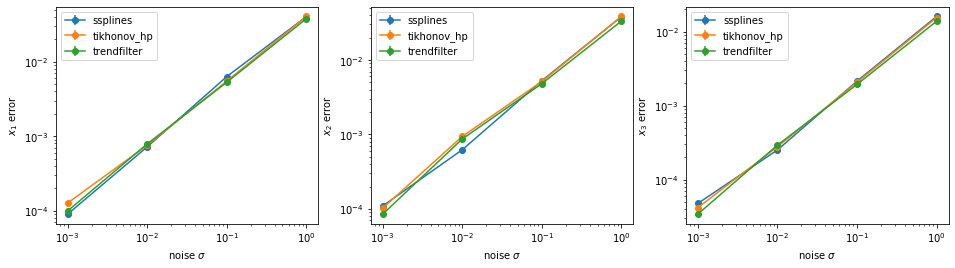

In [10]:
#Display results

#ERROR ON THE STATES

#Create index array
temp1 = [['$\sigma$ = ' + str(x)] * n_states for x in noise_lvls]
noise_indx = np.array([item for sublist in temp1 for item in sublist])
state_indx = np.array(['x' + str(x+1) for x in range(n_states)] * n_noise_lvls)
index_array = [noise_indx, state_indx]

#Create column array
temp2 = [[str(x)] * 2 for x in filter_methods]
filter_indx = np.array([item for sublist in temp2 for item in sublist])
error_indx = np.array(['mean error', 'var. error'] * n_filters)
column_array = [filter_indx, error_indx]

data = []
for filtr in range(n_filters):
    data.append(np.vstack((mean_X_error[:,:,filtr].T.flatten(), var_X_error[:,:,filtr].T.flatten())).T)

data_array = np.hstack(data)

df = pd.DataFrame(data_array, index=index_array, columns=column_array)
pd.options.display.float_format = '{:.4E}'.format
# displaying the DataFrame 
display(df) 

#Plot results
fig, axs = plt.subplots(1, n_states, figsize = (16,4))


for filtr in range(n_filters):
    axs[0].errorbar(noise_lvls, mean_X_error[0,:,filtr], yerr=var_X_error[0,:,filtr], xerr=None, fmt='o-')
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    axs[0].set_ylabel("$x_1$ error")
    axs[0].set_xlabel("noise $\sigma$")
    axs[0].legend(filter_methods)
    axs[1].errorbar(noise_lvls, mean_X_error[1,:,filtr], yerr=var_X_error[1,:,filtr], xerr=None, fmt='o-')
    axs[1].set_xscale("log")
    axs[1].set_yscale("log")
    axs[1].set_ylabel("$x_2$ error")
    axs[1].set_xlabel("noise $\sigma$")
    axs[1].legend(filter_methods)
    axs[2].errorbar(noise_lvls, mean_X_error[2,:,filtr], yerr=var_X_error[2,:,filtr], xerr=None, fmt='o-')
    axs[2].set_xscale("log")
    axs[2].set_yscale("log")
    axs[2].set_ylabel("$x_3$ error")
    axs[2].set_xlabel("noise $\sigma$")
    axs[2].legend(filter_methods)


In [16]:
#Create index array
temp1 = [['$\sigma$ = ' + str(x)] * n_states for x in noise_lvls]
noise_indx = np.array([item for sublist in temp1 for item in sublist])
state_indx = np.array(['x' + str(x+1) for x in range(n_states)] * n_noise_lvls)
index_array = [noise_indx, state_indx]

#Create column array
temp2 = [[str(x),''] for x in filter_methods]
filter_indx = np.array([item for sublist in temp2 for item in sublist])
column_array = [filter_indx]

data = []
for filtr in range(n_filters):
    data.append(np.vstack((mean_X_error[:,:,filtr].T.flatten(), var_X_error[:,:,filtr].T.flatten())).T)

data_array = np.hstack(data)

df = pd.DataFrame(data_array, index=index_array, columns=column_array)
pd.options.display.float_format = '{:.4E}'.format
# displaying the DataFrame 
display(df) 
print(df.to_latex())

ssplines            tikhonov_hp            trendfilter  \
$\sigma$ = 0.001 x1 8.9470E-05 3.6095E-11  1.2613E-04 3.6607E-11  9.8769E-05   
                 x2 1.0980E-04 3.7841E-11  1.0269E-04 2.8912E-11  8.5196E-05   
                 x3 4.7870E-05 5.7400E-12  4.1997E-05 3.8184E-12  3.4347E-05   
$\sigma$ = 0.01  x1 7.1676E-04 2.7043E-09  7.5400E-04 2.4860E-09  7.8565E-04   
                 x2 6.2395E-04 2.5835E-09  9.4143E-04 1.1110E-08  8.7015E-04   
                 x3 2.5228E-04 3.1357E-10  2.7916E-04 8.0725E-10  2.9316E-04   
$\sigma$ = 0.1   x1 6.3157E-03 4.0997E-07  5.4956E-03 3.8231E-07  5.2976E-03   
                 x2 5.2730E-03 2.3291E-07  5.1436E-03 2.3911E-07  4.8130E-03   
                 x3 2.1424E-03 3.9967E-08  2.0664E-03 3.9880E-08  1.9330E-03   
$\sigma$ = 1     x1 4.0411E-02 3.2859E-05  4.0554E-02 3.7164E-05  3.7889E-02   
                 x2 3.8287E-02 1.8989E-05  3.8373E-02 2.5852E-05  3.3338E-02   
                 x3 1.5989E-02 3.7382E-06  1.5439E-02 4.2392E-06  1.3769E-02   

                                
$\sigma$ = 0.001 x1 4.4441E-11  
                 x2 2.2889E-11  
                 x3 4.3669E-12  
$\sigma$ = 0.01  x1 3.9526E-09  
                 x2 6.1098E-09  
                 x3 5.1338E-10  
$\sigma$ = 0.1   x1 3.4382E-07  
                 x2 2.9831E-07  
                 x3 4.7164E-08  
$\sigma$ = 1     x1 3.4382E-05  
                 x2 2.0906E-05  
                 x3 4.2563E-06

\begin{tabular}{llrrrrrr}
\toprule
             &    & \multicolumn{2}{l}{ssplines} & \multicolumn{2}{l}{tikhonov\_hp} & \multicolumn{2}{l}{trendfilter} \\
\midrule
\$\textbackslash sigma\$ = 0.001 & x1 & 8.9470E-05 & 3.6095E-11 &  1.2613E-04 & 3.6607E-11 &  9.8769E-05 & 4.4441E-11 \\
             & x2 & 1.0980E-04 & 3.7841E-11 &  1.0269E-04 & 2.8912E-11 &  8.5196E-05 & 2.2889E-11 \\
             & x3 & 4.7870E-05 & 5.7400E-12 &  4.1997E-05 & 3.8184E-12 &  3.4347E-05 & 4.3669E-12 \\
\$\textbackslash sigma\$ = 0.01 & x1 & 7.1676E-04 & 2.7043E-09 &  7.5400E-04 & 2.4860E-09 &  7.8565E-04 & 3.9526E-09 \\
             & x2 & 6.2395E-04 & 2.5835E-09 &  9.4143E-04 & 1.1110E-08 &  8.7015E-04 & 6.1098E-09 \\
             & x3 & 2.5228E-04 & 3.1357E-10 &  2.7916E-04 & 8.0725E-10 &  2.9316E-04 & 5.1338E-10 \\
\$\textbackslash sigma\$ = 0.1 & x1 & 6.3157E-03 & 4.0997E-07 &  5.4956E-03 & 3.8231E-07 &  5.2976E-03 & 3.4382E-07 \\
             & x2 & 5.2730E-03 & 2.3291E-07 &  5.1436E-03 & 2.3911E-07 

ssplines                 trendfilter  \
                          mean error dx var. error dx mean error dx   
$\sigma$ = 0.001 state x1    1.3050E-03    5.6397E-09    1.9424E-03   
                 state x2    1.4751E-03    1.6328E-09    1.3589E-03   
                 state x3    1.1327E-03    6.9208E-10    1.0478E-03   
$\sigma$ = 0.01  state x1    8.3629E-03    5.1895E-07    1.1036E-02   
                 state x2    6.1883E-03    2.5708E-07    1.2110E-02   
                 state x3    4.6612E-03    1.3904E-07    7.4882E-03   
$\sigma$ = 0.1   state x1    6.1590E-02    4.6246E-05    3.9172E-02   
                 state x2    4.1021E-02    1.3082E-05    3.6397E-02   
                 state x3    3.1520E-02    6.2545E-06    2.7452E-02   
$\sigma$ = 1     state x1    1.6239E-01    4.8643E-04    1.3795E-01   
                 state x2    1.6415E-01    3.5651E-04    1.2073E-01   
                 state x3    1.2851E-01    2.3848E-04    9.1449E-02   

                                          tikhonov_hp                
                          var. error dx mean error dx var. error dx  
$\sigma$ = 0.001 state x1    2.4067E-08    2.8082E-03    2.7374E-08  
                 state x2    9.6002E-09    1.7682E-03    1.2744E-08  
                 state x3    6.4273E-09    1.3651E-03    5.2965E-09  
$\sigma$ = 0.01  state x1    9.6293E-07    1.0286E-02    3.5774E-07  
                 state x2    1.0090E-06    1.5754E-02    7.2568E-06  
                 state x3    4.5119E-07    6.4647E-03    1.8678E-06  
$\sigma$ = 0.1   state x1    1.6175E-05    3.9197E-02    1.6184E-05  
                 state x2    1.6141E-05    3.8245E-02    9.7304E-06  
                 state x3    9.3407E-06    2.8500E-02    4.1611E-06  
$\sigma$ = 1     state x1    5.7111E-04    1.4131E-01    3.7830E-04  
                 state x2    1.8920E-04    1.3600E-01    2.0601E-04  
                 state x3    1.1911E-04    1.0419E-01    1.4656E-04

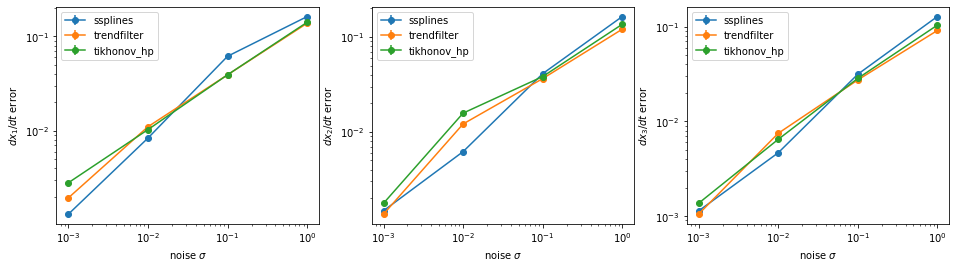

In [4]:
#Display results

#ERROR ON THE DERIVATIVES

#Create index array
temp1 = [['$\sigma$ = ' + str(x)] * n_states for x in noise_lvls]
noise_indx = np.array([item for sublist in temp1 for item in sublist])
state_indx = np.array(['state x' + str(x+1) for x in range(n_states)] * n_noise_lvls)
index_array = [noise_indx, state_indx]

#Create column array
temp2 = [[str(x)] * 2 for x in filter_methods]
filter_indx = np.array([item for sublist in temp2 for item in sublist])
error_indx = np.array(['mean error dx', 'var. error dx'] * n_filters)
column_array = [filter_indx, error_indx]

data = []
for filtr in range(n_filters):
    data.append(np.vstack((mean_dX_error[:,:,filtr].T.flatten(), var_dX_error[:,:,filtr].T.flatten())).T)

data_array = np.hstack(data)

df = pd.DataFrame(data_array, index=index_array, columns=column_array)
pd.options.display.float_format = '{:.4E}'.format
# displaying the DataFrame 
display(df) 

#Plot results
fig, axs = plt.subplots(1, n_states, figsize = (16,4))


for filtr in range(n_filters):
    axs[0].errorbar(noise_lvls, mean_dX_error[0,:,filtr], yerr=var_dX_error[0,:,filtr], xerr=None, fmt='o-')
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    axs[0].set_ylabel("$dx_1 / dt$ error")
    axs[0].set_xlabel("noise $\sigma$")
    axs[0].legend(filter_methods)
    axs[1].errorbar(noise_lvls, mean_dX_error[1,:,filtr], yerr=var_dX_error[1,:,filtr], xerr=None, fmt='o-')
    axs[1].set_xscale("log")
    axs[1].set_yscale("log")
    axs[1].set_ylabel("$dx_2 / dt$ error")
    axs[1].set_xlabel("noise $\sigma$")
    axs[1].legend(filter_methods)
    axs[2].errorbar(noise_lvls, mean_dX_error[2,:,filtr], yerr=var_dX_error[2,:,filtr], xerr=None, fmt='o-')
    axs[2].set_xscale("log")
    axs[2].set_yscale("log")
    axs[2].set_ylabel("$dx_3 / dt$ error")
    axs[2].set_xlabel("noise $\sigma$")
    axs[2].legend(filter_methods)

In [5]:
Y_samples = []
dY_samples = []

system = 'Lorenz63'
filter_methods = ['tikhonov_diff','trendfilter_diff']
# filter_methods = ['tikhonov_diff']

n_filters = len(filter_methods)

#Load true dynamical system data
filepath_xt = 'data_files/' + system + '_dynamics.csv'
dynamics = np.genfromtxt(filepath_xt, delimiter=',')

t = dynamics[0]
data = dynamics[1:]
t_samples = len(t)
trim = int(np.floor(5 / 100 * t_samples))

n_states = int(data.shape[0] / 2)
X = data[0:n_states,trim:-trim]
DX = data[n_states:,trim:-trim]
tt = t[trim:-trim]
n_samples = 100

noise_lvls = [0.001, 0.01, 0.1, 1]
n_noise_lvls = len(noise_lvls)

mean_dX_error = np.zeros((n_states, n_noise_lvls, n_filters))
var_dX_error = np.zeros((n_states, n_noise_lvls, n_filters))

error_dX = np.zeros((n_samples,n_states))

for filter_idx, filter_method in enumerate(filter_methods):
    
    for noise_lvl, sigma in enumerate(noise_lvls):

        #Load sample observations
        for state in range(n_states):
            filepath_dy = 'data_files/' + filter_method+ '/' + system + '_' + filter_method + '_' + str(sigma) + '_dY' + str(state+1) + '.csv'
            dy = np.genfromtxt(filepath_dy, delimiter=',')

            n_samples = dy.shape[0]
            print(n_samples)
            for sample in range(n_samples):

                error_dX[sample,state] = norm(dy[sample,:] - DX[state,:]) / norm(DX[state,:])

            mean_dX_error[state, noise_lvl, filter_idx] = error_dX[:,state].mean()
            var_dX_error[state, noise_lvl, filter_idx] = error_dX[:,state].var()


100
100
100
100
100
100
100
100
100
100
100
100
99
100
100
98
100
98
80
94
66
86
92
90


tikhonov_diff               trendfilter_diff  \
                          mean error dx var. error dx    mean error dx   
$\sigma$ = 0.001 state x1    1.2398E-03    2.0746E-09       2.6378E-03   
                 state x2    1.8130E-03    1.4602E-09       1.5604E-03   
                 state x3    1.5861E-03    5.7025E-10       1.4268E-03   
$\sigma$ = 0.01  state x1    4.9970E-03    2.6037E-07       5.0256E-03   
                 state x2    4.1997E-03    9.9630E-08       3.9515E-03   
                 state x3    3.2727E-03    4.5613E-08       2.8796E-03   
$\sigma$ = 0.1   state x1    2.6595E-02    1.2933E-05       1.7432E-02   
                 state x2    2.4663E-02    7.2085E-06       1.5382E-02   
                 state x3    1.8652E-02    3.6631E-06       9.6950E-03   
$\sigma$ = 1     state x1    1.3355E-01    3.6718E-04       1.1436E-01   
                 state x2    1.2034E-01    1.9668E-04       1.1672E-01   
                 state x3    9.4293E-02    1.7104E-04       7.3913E-02   

                                         
                          var. error dx  
$\sigma$ = 0.001 state x1    2.0134E-04  
                 state x2    1.8669E-09  
                 state x3    8.6230E-10  
$\sigma$ = 0.01  state x1    1.9474E-04  
                 state x2    8.1692E-08  
                 state x3    6.5524E-08  
$\sigma$ = 0.1   state x1    2.0710E-04  
                 state x2    1.5301E-05  
                 state x3    2.7408E-05  
$\sigma$ = 1     state x1    2.3610E-03  
                 state x2    1.3947E-03  
                 state x3    7.1817E-04

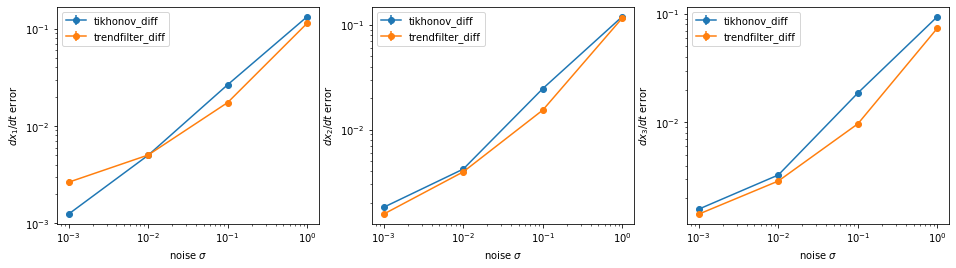

In [6]:
#Display results

#ERROR ON THE DERIVATIVES

#Create index array
temp1 = [['$\sigma$ = ' + str(x)] * n_states for x in noise_lvls]
noise_indx = np.array([item for sublist in temp1 for item in sublist])
state_indx = np.array(['state x' + str(x+1) for x in range(n_states)] * n_noise_lvls)
index_array = [noise_indx, state_indx]

#Create column array
temp2 = [[str(x)] * 2 for x in filter_methods]
filter_indx = np.array([item for sublist in temp2 for item in sublist])
error_indx = np.array(['mean error dx', 'var. error dx'] * n_filters)
column_array = [filter_indx, error_indx]

data = []
for filtr in range(n_filters):
    data.append(np.vstack((mean_dX_error[:,:,filtr].T.flatten(), var_dX_error[:,:,filtr].T.flatten())).T)

data_array = np.hstack(data)

df = pd.DataFrame(data_array, index=index_array, columns=column_array)
pd.options.display.float_format = '{:.4E}'.format
# displaying the DataFrame 
display(df) 

#Plot results
fig, axs = plt.subplots(1, n_states, figsize = (16,4))


for filtr in range(n_filters):
    axs[0].errorbar(noise_lvls, mean_dX_error[0,:,filtr], yerr=var_dX_error[0,:,filtr], xerr=None, fmt='o-')
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    axs[0].set_ylabel("$dx_1 / dt$ error")
    axs[0].set_xlabel("noise $\sigma$")
    axs[0].legend(filter_methods)
    axs[1].errorbar(noise_lvls, mean_dX_error[1,:,filtr], yerr=var_dX_error[1,:,filtr], xerr=None, fmt='o-')
    axs[1].set_xscale("log")
    axs[1].set_yscale("log")
    axs[1].set_ylabel("$dx_2 / dt$ error")
    axs[1].set_xlabel("noise $\sigma$")
    axs[1].legend(filter_methods)
    axs[2].errorbar(noise_lvls, mean_dX_error[2,:,filtr], yerr=var_dX_error[2,:,filtr], xerr=None, fmt='o-')
    axs[2].set_xscale("log")
    axs[2].set_yscale("log")
    axs[2].set_ylabel("$dx_3 / dt$ error")
    axs[2].set_xlabel("noise $\sigma$")
    axs[2].legend(filter_methods)

In [ ]:
# #Display results

# #ERROR ON THE STATES

# #Create index array
# temp1 = [['$\sigma$ = ' + str(x)] * n_states for x in noise_lvls]
# noise_indx = np.array([item for sublist in temp1 for item in sublist])
# state_indx = np.array(['state x' + str(x+1) for x in range(n_states)] * n_noise_lvls)
# index_array = [noise_indx, state_indx]

# #Create column array
# temp2 = [[str(x)] * 4 for x in filter_methods]
# filter_indx = np.array([item for sublist in temp2 for item in sublist])
# error_indx = np.array(['mean error x', 'var. error x', 'mean error dx', 'var. error dx'] * n_filters)
# column_array = [filter_indx, error_indx]

# data = []
# for filtr in range(n_filters):
#     data.append(np.vstack((mean_X_error[:,:,filtr].T.flatten(), var_X_error[:,:,filtr].T.flatten(), mean_dX_error[:,:,filtr].T.flatten(), var_dX_error[:,:,filtr].T.flatten())).T)

# data_array = np.hstack(data)

# df = pd.DataFrame(data_array, index=index_array, columns=column_array)
# pd.options.display.float_format = '${:.4E}'.format
# # displaying the DataFrame 
# display(df) 